In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import PIL
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder

2023-05-23 13:22:25.110877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
file = []
labels = []
resized_image = []
for dirname,_, filenames in os.walk('lung_colon_image_set'):
    for filename in filenames:
        if not filename.lower().endswith('.ds_store'):
            if "lung_aca" in dirname:
                labels.append("Lung Adenocarcinoma")
            elif "lung_n" in dirname:
                labels.append("Lung Benign Tissue")
            elif "lung_scc" in dirname:
                labels.append("Lung Squamous Cell Carcinoma")
            elif "colon_n" in dirname:
                labels.append("Colon Benign Tissue")
            elif "colon_aca" in dirname:
                labels.append("Colon Adenocarcinoma")
            file.append(os.path.join(dirname, filename))

In [3]:
Slabels = pd.Series(labels,name="Labels")
Sfile  = pd.Series(file,name="Filepaths")
data = pd.concat([Sfile,Slabels],axis=1)

In [4]:
data.head()

,Filepaths,Labels
0,lung_colon_image_set/lung_aca/lungaca2296.jpeg,Lung Adenocarcinoma
1,lung_colon_image_set/lung_aca/lungaca1843.jpeg,Lung Adenocarcinoma
2,lung_colon_image_set/lung_aca/lungaca294.jpeg,Lung Adenocarcinoma
3,lung_colon_image_set/lung_aca/lungaca3487.jpeg,Lung Adenocarcinoma
4,lung_colon_image_set/lung_aca/lungaca4342.jpeg,Lung Adenocarcinoma


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filepaths  25000 non-null  object
 1   Labels     25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [6]:
data.isnull().sum()

Filepaths    0
Labels       0
dtype: int64

In [7]:
data['Labels'].value_counts()

Lung Adenocarcinoma             5000
Colon Benign Tissue             5000
Colon Adenocarcinoma            5000
Lung Benign Tissue              5000
Lung Squamous Cell Carcinoma    5000
Name: Labels, dtype: int64

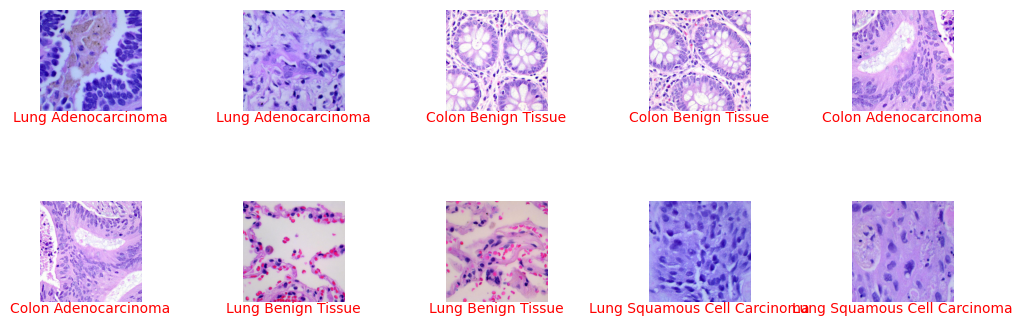

In [8]:
transform = transforms.Compose([transforms.ToTensor()])
grouped = data.groupby('Labels').head(2)

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the groups and plot the images in the subplots
for i, (_, row) in enumerate(grouped.iterrows()):
    # Extract the filepath and label from the row
    filepath = row['Filepaths']
    label = row['Labels']

    # Convert the filepath to a string
    filepath = str(filepath)

    # Open the image file
    image = plt.imread(filepath)

    # Plot the image in the corresponding subplot
    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.axis('off')
    annotation_x = 768 // 2
    annotation_y = 768 + 2
    # Annotate the image with its label
    ax.annotate(label, (annotation_x, annotation_y), color='red', ha='center', va='top')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
preprocessed_df.head()

NameError: name 'preprocessed_df' is not defined

In [ ]:
len(preprocessed_df['Filepaths'][0])

In [ ]:
encoder = LabelEncoder()
encoded = encoder.fit_transform(data['Labels'])
data["Labels"] = encoder.fit_transform(data['Labels'])
reverse_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
# Print the mapping
for number, label in reverse_mapping.items():
    print("Number: {}, Label: {}".format(number, label))

In [9]:
traindf,validationdf = train_test_split(data,random_state=25,train_size=0.8,stratify = data['Labels'])
validationdf,testdf = train_test_split(validationdf,random_state=25,train_size=0.5 ,stratify = validationdf['Labels'])

In [16]:
def preprocess_image(image_path):
    # Load the image
    image = Image.open(image_path)
    # Perform any necessary preprocessing steps on the image
    # and normalize the pixel values
    resized_image = image.resize((256, 256))  # Resize the image to 256x256
    #convert the image to array
    #image_array = np.array(resized_image)
    
    # Flatten the array to a 1D vector
    #image_vector = image_array.flatten()
    # Normalize the pixel values to be between 0 and 1
    #normalized_image = image_vector / 255.0

    return resized_image

# Preprocess the data
preprocessed_df = [preprocess_image(image_path) for image_path in traindf["Filepaths"]]

In [ ]:
preprocessed_df

In [ ]:
traindf["Labels"].value_counts()

In [ ]:
validationdf['Labels'].value_counts()

In [ ]:
testdf['Labels'].value_counts()

In [ ]:
#import numpy as np

#def preprocess_image(image_path):
    # Load the image using OpenCV
 #   image = Image.open(image_path)
    
    # Perform any necessary preprocessing steps on the image
    # For example, you can resize the image to a specific size
    # and normalize the pixel values
    
  #  resized_image = image.resize((256, 256))  # Resize the image to 256x256
    
    # Normalize the pixel values to be between 0 and 1
   # normalized_image = resized_image / 255
    
    #return normalized_image

# Preprocess the training data
#X_train_preprocessed = [preprocess_image(image_path) for image_path in traindf["Filepaths"]]

# Preprocess the testing data
#X_test_preprocessed = [preprocess_image(image_path) for image_path in testdf['Filepaths']]


In [ ]:
#vector = []
#for image in X_train_preprocessed:
 #   if isinstance(image, PIL.Image.Image):
  #      vector.append(np.array(image))
   # else:
    #    # Handle the case when the element is not a valid PIL.Image.Image object
     #   print("Skipping invalid image:", image)

# Check the shapes of the images in the vector
#image_shapes = [image.shape for image in vector]
#print(image_shapes)

In [18]:
image_vectors= [] 
for image in preprocessed_df:
    # Resize image to the target size    
    # Convert image to a numpy array
    image_array = np.array(image)/255.0
 #   
    # Flatten the array to a 1D vector
    image_vectors.append(image_array)

# Convert the list of image vectors to a numpy array
#X_train_vectors = np.array(image_vectors)

# Check the shape of the resulting array
print(image_vectors[0])

[[[0.3254902  0.10980392 0.63529412]
  [0.40784314 0.24705882 0.72941176]
  [0.60392157 0.49019608 0.87843137]
  ...
  [0.9254902  0.8745098  0.91764706]
  [0.9372549  0.89411765 0.9254902 ]
  [0.95294118 0.90980392 0.93333333]]

 [[0.41960784 0.24313725 0.76078431]
  [0.46666667 0.33333333 0.79607843]
  [0.59607843 0.49803922 0.85490196]
  ...
  [0.92156863 0.8745098  0.91372549]
  [0.94509804 0.89803922 0.91372549]
  [0.95686275 0.90980392 0.91372549]]

 [[0.54509804 0.39215686 0.92941176]
  [0.5372549  0.40784314 0.88627451]
  [0.60392157 0.49803922 0.86666667]
  ...
  [0.92156863 0.85098039 0.90980392]
  [0.94117647 0.87843137 0.89803922]
  [0.95294118 0.89411765 0.89803922]]

 ...

 [[0.97254902 0.8627451  0.88235294]
  [0.81568627 0.65490196 0.83921569]
  [0.63921569 0.43921569 0.81960784]
  ...
  [0.84705882 0.61568627 0.94117647]
  [0.82745098 0.58823529 0.94509804]
  [0.81960784 0.58039216 0.94901961]]

 [[0.94117647 0.80392157 0.8745098 ]
  [0.71372549 0.5254902  0.79215686]


In [ ]:
#len(X_train_vectors[0])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

In [17]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(image):
    print("Image shape:", image.shape)
    print("Image data type:", image.dtype)
    #image = Image.fromarray(image)

    # Convert image to a numpy array
    #image = image.convert("RGB")

    #image_array = np.array(image)

    # Resize image to the target size
    #resized_image = np.resize(image_array, (256, 256))

    # Normalize the pixel values to be between 0 and 1
    normalized_image = image / 255.0

    return normalized_image

# Create an ImageDataGenerator
data_generator = ImageDataGenerator(preprocessing_function=preprocess_image)

# Define the batch size and total number of images
batch_size = 100
total_images = len(preprocessed_df)

# Create a generator for the images
image_generator = data_generator.flow_from_dataframe(
    dataframe=preprocessed_df,
    x_col='Filepaths',
    y_col='Labels',
    batch_size=batch_size,
    shuffle=False,  # Ensure consistent order of images
    target_size=(256, 256),
    class_mode=None  # This will return only the image data
)

# Initialize an empty list to store the image vectors
image_vectors = []

# Process the images in batches
for i in range(len(image_generator)):
    batch_images = image_generator[i]

    # Process the batch of images and append the image vectors
    for image in batch_images:
        # Flatten the image array to a 1D vector
        image_vector = image.flatten()

        # Append the image vector to the list
        image_vectors.append(image_vector)

    # Clear the memory
    del batch_images
    gc.collect()

# Convert the list of image vectors to a numpy array
image_vectors = np.array(image_vectors)



TypeError: list indices must be integers or slices, not str